In [ ]:
!pip install --quiet pdfplumber PyMuPDF sentence-transformers faiss-cpu
!pip install streamlit ngrok pdfplumber matplotlib seaborn faiss-cpu sentence-transformers --quiet
!pip install google-cloud-vision


In [ ]:
import pdfplumber
import numpy as np
import faiss
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sentence_transformers import SentenceTransformer
import re
import sys


Saving order_10248.pdf to order_10248.pdf
Uploaded file: order_10248.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Financial data extraction complete. Saved to 'financials.csv'.


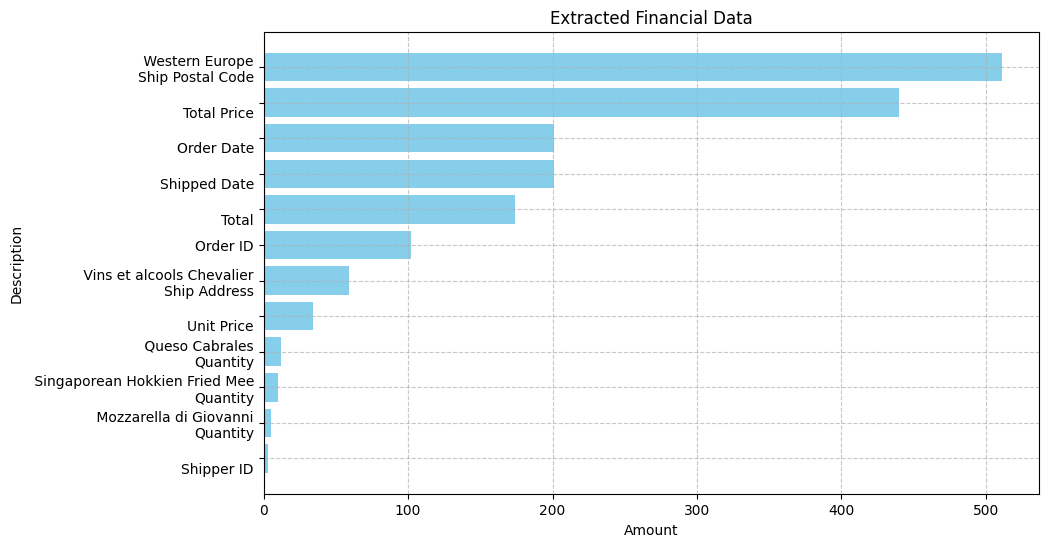

In [ ]:
# Step 1: Upload the PDF
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_path}")

# Step 2: Extract Text from PDF with Error Handling
def extract_text_from_pdf(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page_num, page in enumerate(pdf.pages):
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
            if not text.strip():
                raise ValueError("No readable text found in the PDF.")
            return text
    except Exception as e:
        sys.exit(f"Error extracting text: {e}")

extracted_text = extract_text_from_pdf(pdf_path)
text_sentences = [line.strip().lower() for line in extracted_text.split("\n") if line.strip()]

# Step 3: Extract and Organize Financial Data
def extract_financials(text):
    pattern = r'([A-Za-z\s]+)\s*[:\-]?\s*(\$?\d{1,3}(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)
    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df['Amount'] = df['Amount'].replace({'\\$': '', ',': ''}, regex=True).astype(float)
    df = df.sort_values(by="Amount", ascending=False)
    return df

financial_df = extract_financials(extracted_text)

# Step 4: Save Organized Financial Data to CSV
financial_df.to_csv("financials.csv", index=False)
files.download("financials.csv")
print("Financial data extraction complete. Saved to 'financials.csv'.")

# Step 5: Create a Bar Chart of Financial Data
plt.figure(figsize=(10, 6))
plt.barh(financial_df['Description'], financial_df['Amount'], color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Description')
plt.title('Extracted Financial Data')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Step 6: Generate Embeddings and FAISS Index
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text_sentences)
np.save("embeddings.npy", embeddings)
with open("sentences.pkl", "wb") as f:
    pickle.dump(text_sentences, f)
files.download("embeddings.npy")
files.download("sentences.pkl")

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
faiss.write_index(index, "faiss_index.index")
files.download("faiss_index.index")
print("FAISS index created and downloaded.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FAISS index created and downloaded.


In [ ]:
# Load embeddings and FAISS index
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")

# Load text sentences
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

print(f"Loaded {len(text_sentences)} sentences and FAISS index with {index.ntotal} entries.")


Loaded 37 sentences and FAISS index with 37 entries.


In [ ]:
# Load FAISS index and sentences (from Step 1)
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

# Load embedding model for queries
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def search_financial_query(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    results = [(text_sentences[i], distances[0][j]) for j, i in enumerate(indices[0])]
    return results

# Example Query
query = "Total revenue for Q4"
results = search_financial_query(query)

print(f"Results for query: '{query}'")
for text, distance in results:
    print(f"- {text} (Distance: {distance:.4f})")


Results for query: 'Total revenue for Q4'
- total: 174.0 (Distance: 1.1500)
- total: 168.0 (Distance: 1.1606)
- total price: (Distance: 1.1889)
- total: 98.0 (Distance: 1.1942)
- total price: 440.0 (Distance: 1.2827)


In [ ]:
# Step 3: Enhanced Financial Summarization with Insights (Phase 2)
import pandas as pd
import numpy as np
import re

# Load financial data from CSV (from Phase 1 output)
financial_df = pd.read_csv("financials.csv")

# Function to generate a comprehensive financial summary with descriptions
def generate_financial_summary(df):
    total_amount = df['Amount'].sum()
    average_amount = df['Amount'].mean()
    median_amount = df['Amount'].median()
    top_expense = df.loc[df['Amount'].idxmax()]
    lowest_expense = df.loc[df['Amount'].idxmin()]

    # Key insights
    high_value_transactions = df[df['Amount'] > average_amount]
    frequent_expense_categories = df['Description'].value_counts().head(3)

    # Insight Descriptions
    summary = {
        "Total Amount": f"The total sum of all financial transactions is ${total_amount:.2f}.",
        "Average Transaction": f"The average transaction amount is ${average_amount:.2f}.",
        "Median Transaction": f"The median transaction amount, representing the midpoint of all transactions, is ${median_amount:.2f}.",
        "Highest Expense": f"The largest single expense recorded is {top_expense['Description']} totaling ${top_expense['Amount']:.2f}.",
        "Lowest Expense": f"The smallest single expense is {lowest_expense['Description']} at ${lowest_expense['Amount']:.2f}.",
        "Number of Transactions": f"A total of {len(df)} transactions were recorded.",
        "High-Value Transactions Count": f"There are {len(high_value_transactions)} transactions exceeding the average amount.",
        "Top Expense Categories": f"The most frequent expense categories are {frequent_expense_categories.to_dict()}"
    }
    return summary

# Display financial summary with key insights and descriptions
summary = generate_financial_summary(financial_df)
print("Enhanced Financial Summary with Descriptions and Key Insights:")
for key, value in summary.items():
    print(f"{key}: {value}")


Enhanced Financial Summary with Descriptions and Key Insights:
Total Amount: The total sum of all financial transactions is $2041.00.
Average Transaction: The average transaction amount is $127.56.
Median Transaction: The median transaction amount, representing the midpoint of all transactions, is $78.50.
Highest Expense: The largest single expense recorded is  Western Europe
Ship Postal Code totaling $511.00.
Lowest Expense: The smallest single expense is 
Shipper ID at $3.00.
Number of Transactions: A total of 16 transactions were recorded.
High-Value Transactions Count: There are 6 transactions exceeding the average amount.
Top Expense Categories: The most frequent expense categories are {'\nTotal': 3, '\nUnit Price': 3, ' Western Europe\nShip Postal Code': 1}


<ipython-input-9-37b842600f13>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")


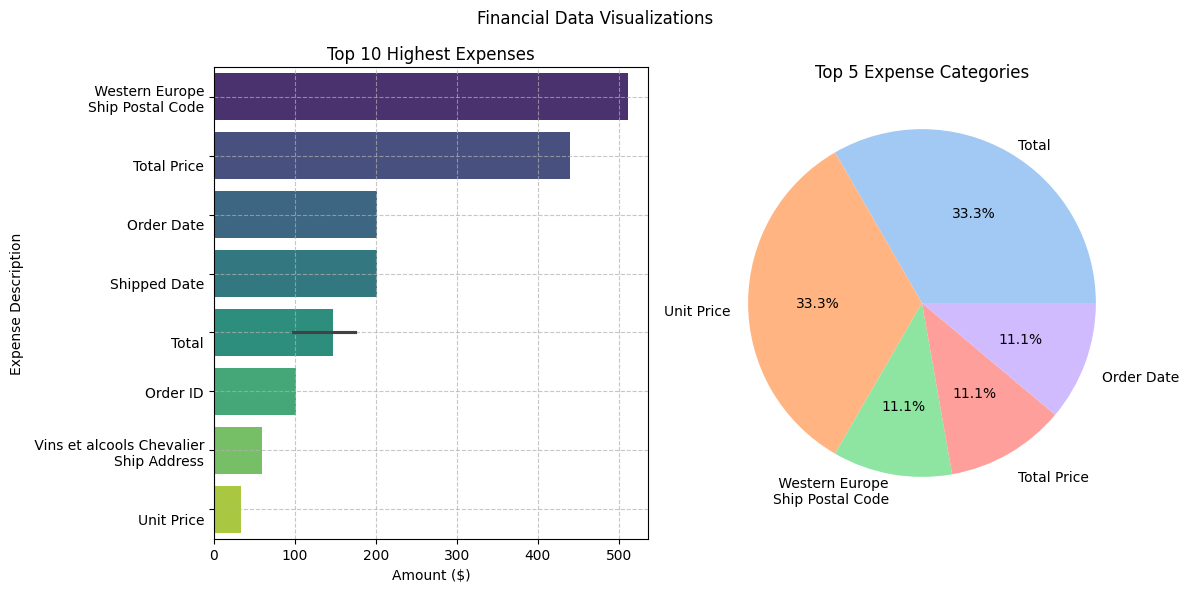

Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.


In [ ]:
# Step 4: Visualization of Financial Insights (Phase 2)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load financial data from CSV
financial_df = pd.read_csv("financials.csv")

# Create visualizations from financial summary
plt.figure(figsize=(12, 6))

# Bar chart of top expenses
top_expenses = financial_df.nlargest(10, 'Amount')
plt.subplot(1, 2, 1)
sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")
plt.title('Top 10 Highest Expenses')
plt.xlabel('Amount ($)')
plt.ylabel('Expense Description')
plt.grid(True, linestyle='--', alpha=0.7)

# Pie chart of top expense categories
category_counts = financial_df['Description'].value_counts().head(5)
plt.subplot(1, 2, 2)
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 5 Expense Categories')

plt.suptitle('Financial Data Visualizations')
plt.tight_layout()
plt.show()

print("Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.")


# New Section

In [24]:
!pip install streamlit

In [25]:
from transformers import pipeline
from PIL import Image
from sentence_transformers import SentenceTransformer, util
import requests

qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Device set to use cpu


In [ ]:
!pip install streamlit pandas pdfplumber openpyxl transformers sentence-transformers seaborn

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statistics import mean
import json

In [54]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pdfplumber
import openpyxl
import re
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statistics import mean
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# -------------------- Streamlit UI Configuration --------------------
st.set_page_config(page_title="FinancialSage", page_icon="☾𖤓", layout="wide")

# -------------------- Load NLP Models --------------------
@st.cache_resource
def load_qa_pipeline():
    return pipeline("question-answering", model="deepset/roberta-base-squad2")

@st.cache_resource
def load_embedder():
    return SentenceTransformer('all-MiniLM-L6-v2')

qa_pipeline = load_qa_pipeline()
embedder = load_embedder()

# -------------------- Helper Functions --------------------
def extract_text_from_pdf(pdf_file):
    text = ""
    try:
        with pdfplumber.open(pdf_file) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        st.error(f"Error processing PDF: {e}")
        return ""
    return text

def extract_financials(text):
    pattern = r'([A-Za-z0-9,\.\-\(\)\s]+)\s*[:\-]?\s*([\\$]?\d+(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)

    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df["Description"] = df["Description"].str.strip()
    df = df[df["Description"] != ""]

    try:
        df["Amount"] = (
            df["Amount"]
            .replace({"\\$": "", ",": ""}, regex=True)
            .astype(float)
        )
    except ValueError as e:
        st.error(f"Error converting amounts: {e}")
        return pd.DataFrame(columns=["Description", "Amount", "Formatted Amount"])

    df.dropna(subset=["Amount"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["Formatted Amount"] = df["Amount"].apply(lambda x: f"${x:,.2f}")
    df.reset_index(drop=True, inplace=True)

    return df

def create_visualization(data, chart_type, x_col, y_col):
    fig = go.Figure()

    if chart_type == "Bar Chart":
        fig.add_trace(go.Bar(x=data[x_col], y=data[y_col]))
    elif chart_type == "Line Chart":
        fig.add_trace(go.Scatter(x=data[x_col], y=data[y_col], mode='lines+markers'))
    elif chart_type == "Pie Chart":
        fig.add_trace(go.Pie(labels=data[x_col].head(8), values=data[y_col].head(8)))
    elif chart_type == "Scatter Plot":
        fig.add_trace(go.Scatter(x=data[x_col], y=data[y_col], mode='markers'))
    elif chart_type == "Box Plot":
        fig.add_trace(go.Box(x=data[x_col], y=data[y_col]))
    elif chart_type == "Histogram":
        fig.add_trace(go.Histogram(x=data[y_col]))

    fig.update_layout(
        title=f"{chart_type} - {x_col} vs {y_col}",
        xaxis_title=x_col,
        yaxis_title=y_col,
        height=400
    )

    return fig

def create_kpi_metrics(df):
    metrics = {}

    if 'Amount' in df.columns:
        metrics['total_amount'] = df['Amount'].sum()
        metrics['average_amount'] = df['Amount'].mean()
        metrics['transaction_count'] = len(df)

        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            monthly_totals = df.groupby(df['Date'].dt.to_period('M'))['Amount'].sum()
            if len(monthly_totals) > 1:
                current = monthly_totals.iloc[-1]
                previous = monthly_totals.iloc[-2]
                metrics['mom_growth'] = ((current - previous) / previous) * 100

    return metrics

def create_interactive_dashboard(df):
    st.header("📊 Financial Dashboard")

    # KPI Section
    st.subheader("Key Performance Indicators")
    metrics = create_kpi_metrics(df)

    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric(
            label="Total Amount",
            value=f"${metrics.get('total_amount', 0):,.2f}",
            delta=f"{metrics.get('mom_growth', 0):.1f}%" if 'mom_growth' in metrics else None
        )
    with col2:
        st.metric(
            label="Average Transaction",
            value=f"${metrics.get('average_amount', 0):,.2f}"
        )
    with col3:
        st.metric(
            label="Transaction Count",
            value=f"{metrics.get('transaction_count', 0):,}"
        )

    # Charts Section
    st.subheader("Financial Analytics")

    col1, col2 = st.columns(2)
    with col1:
        if 'Amount' in df.columns:
            fig = go.Figure()
            fig.add_trace(go.Histogram(
                x=df['Amount'],
                nbinsx=30,
                name='Amount Distribution'
            ))
            fig.update_layout(
                title="Amount Distribution",
                xaxis_title="Amount ($)",
                yaxis_title="Frequency",
                height=400
            )
            st.plotly_chart(fig, use_container_width=True)

    with col2:
        if 'Description' in df.columns and 'Amount' in df.columns:
            top_categories = df.groupby('Description')['Amount'].sum().nlargest(5)
            fig = go.Figure(data=[
                go.Bar(x=top_categories.index, y=top_categories.values)
            ])
            fig.update_layout(
                title="Top 5 Categories by Amount",
                xaxis_title="Category",
                yaxis_title="Total Amount ($)",
                height=400
            )
            st.plotly_chart(fig, use_container_width=True)

    # Detailed Data View
    st.subheader("Detailed Data Analysis")

    selected_columns = st.multiselect(
        "Select Columns to Display",
        options=df.columns,
        default=list(df.columns)
    )

    st.dataframe(
        df[selected_columns],
        use_container_width=True,
        height=400
    )

def process_query(query, data_df, text_content=""):
    if text_content:
        try:
            embeddings = embedder.encode([query, text_content], convert_to_tensor=True)
            similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])
            result = qa_pipeline(question=query, context=text_content)
            return result['answer'], similarity_score.item()
        except Exception as e:
            return f"Error processing query: {e}", 0.0
    else:
        try:
            numeric_cols = data_df.select_dtypes(include=[np.number]).columns
            query_lower = query.lower()

            response = []
            if 'average' in query_lower or 'mean' in query_lower:
                for col in numeric_cols:
                    response.append(f"Average {col}: ${data_df[col].mean():,.2f}")
            elif 'maximum' in query_lower or 'highest' in query_lower:
                for col in numeric_cols:
                    response.append(f"Maximum {col}: ${data_df[col].max():,.2f}")
            elif 'minimum' in query_lower or 'lowest' in query_lower:
                for col in numeric_cols:
                    response.append(f"Minimum {col}: ${data_df[col].min():,.2f}")
            elif 'total' in query_lower or 'sum' in query_lower:
                for col in numeric_cols:
                    response.append(f"Total {col}: ${data_df[col].sum():,.2f}")
            else:
                response.append("I can answer questions about averages, maximums, minimums, and totals in your data.")

            return "\n".join(response), 1.0
        except Exception as e:
            return f"Error analyzing data: {e}", 0.0

# -------------------- Main App --------------------
def main():
    st.title("☾𖤓 Financial Sage")

    with st.sidebar:
        st.header("Upload Options")
        upload_type = st.radio("Choose upload type:", ["Single File", "Multiple Files"])

    if upload_type == "Single File":
        uploaded_file = st.file_uploader(
            "Upload a financial document:",
            type=["csv", "xlsx", "pdf"]
        )

        if uploaded_file:
            st.header(f"Processing: {uploaded_file.name}")

            # Process the file
            if uploaded_file.name.endswith('.pdf'):
                text_content = extract_text_from_pdf(uploaded_file)
                with st.expander("📄 Document Content", expanded=True):
                    st.text_area("Content:", text_content, height=200)
                df = extract_financials(text_content)
            else:
                try:
                    df = pd.read_excel(uploaded_file) if uploaded_file.name.endswith('.xlsx') else pd.read_csv(uploaded_file)
                    text_content = ""
                except Exception as e:
                    st.error(f"Error reading file: {e}")
                    return

            # Create tabs for different sections
            tab1, tab2, tab3, tab4 = st.tabs(["Data Analysis", "Visualizations", "Interactive Dashboard", "Query Tool"])

            with tab1:
                st.dataframe(df)
                csv = df.to_csv(index=False).encode('utf-8')
                st.download_button(
                    "📥 Download Data (CSV)",
                    csv,
                    f"processed_{uploaded_file.name}.csv",
                    "text/csv"
                )

            with tab2:
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                selected_charts = st.multiselect(
                    "Select charts to generate:",
                    ["Bar Chart", "Line Chart", "Pie Chart", "Scatter Plot", "Box Plot", "Histogram"],
                    default=["Bar Chart"]
                )

                if selected_charts:
                    col1, col2 = st.columns(2)
                    with col1:
                        x_col = st.selectbox("Select X-axis:", df.columns)
                    with col2:
                        y_col = st.selectbox("Select Y-axis:", numeric_cols)

                    if st.button("Generate Charts"):
                        for chart_type in selected_charts:
                            fig = create_visualization(df, chart_type, x_col, y_col)
                            st.plotly_chart(fig, use_container_width=True)

            with tab3:
                create_interactive_dashboard(df)

            with tab4:
                query = st.text_input("Enter your question about the data:")
                if query:
                    answer, confidence = process_query(query, df, text_content)
                    st.write(f"**Answer:** {answer}")
                    if confidence > 0:
                        st.write(f"**Confidence Score:** {confidence:.2f}")

    else:  # Multiple Files
        uploaded_files = st.file_uploader(
            "Upload multiple documents:",
            accept_multiple_files=True,
            type=["csv", "xlsx", "pdf"]
        )

        if uploaded_files:
            all_dfs = {}
            combined_text = ""

            for file in uploaded_files:
                with st.expander(f"📄 {file.name}", expanded=True):
                    if file.name.endswith('.pdf'):
                        text = extract_text_from_pdf(file)
                        combined_text += text
                        st.text_area("Content:", text, height=200)
                        df = extract_financials(text)
                    else:
                        try:
                            df = pd.read_excel(file) if file.name.endswith('.xlsx') else pd.read_csv(file)
                        except Exception as e:
                            st.error(f"Error reading {file.name}: {e}")
                            continue

                    df['Source'] = file.name
                    all_dfs[file.name] = df

                    st.dataframe(df)
                    csv = df.to_csv(index=False).encode('utf-8')
                    st.download_button(
                        f"📥 Download {file.name} Data",
                        csv,
                        f"processed_{file.name}.csv",
                        "text/csv"
                    )

            if all_dfs:
                combined_df = pd.concat(all_dfs.values(), ignore_index=True)

                tab1, tab2, tab3, tab4 = st.tabs(["Combined Data", "Visualizations", "Interactive Dashboard", "Query Tool"])

                with tab1:
                    st.dataframe(combined_df)
                    combined_csv = combined_df.to_csv(index=False).encode('utf-8')
                    st.download_button(
                        "📥 Download Combined Data",
                        combined_csv,
                        "combined_analysis.csv",
                        "text/csv"
                    )

                with tab2:
                    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
                    selected_charts = st.multiselect(
                        "Select charts to generate:",
                        ["Bar Chart", "Line Chart", "Pie Chart", "Scatter Plot", "Box Plot", "Histogram"],
                        default=["Bar Chart"]
                    )

                    if selected_charts:
                        col1, col2 = st.columns(2)
                        with col1:
                            x_col = st.selectbox("Select X-axis:", combined_df.columns)
                        with col2:
                            y_col = st.selectbox("Select Y-axis:", numeric_cols)

                        if st.button("Generate Charts"):
                            for chart_type in selected_charts:
                                fig = create_visualization(combined_df, chart_type, x_col, y_col)
                                st.plotly_chart(fig, use_container_width=True)

                with tab3:
                    create_interactive_dashboard(combined_df)

                with tab4:
                  query = st.text_input("Enter your question about the combined data:")
                  if query:
                    answer, confidence = process_query(query, combined_df, combined_text)
                    st.write(f"**Answer:** {answer}")
                    if confidence > 0:
                      st.write(f"**Confidence Score:** {confidence:.2f}")

if __name__ == "__main__":
    main()

Overwriting app.py


In [52]:
!pip install pyngrok --quiet
!ngrok config add-authtoken 2szpvdGz6Ms1XqMAjv68ZuAI0NM_5Kw7D3XSi6eQCGZ9nFCEu

import os
import signal
import subprocess
import time
from pyngrok import ngrok

# Function to kill all ngrok processes
def kill_ngrok():
    try:
        # Find and kill ngrok processes
        process = subprocess.Popen(['ps', '-aux'], stdout=subprocess.PIPE)
        output, _ = process.communicate()
        for line in output.decode('utf-8').splitlines():
            if 'ngrok' in line and 'start' not in line:  # Avoid killing the new ngrok process
                pid = int(line.split()[1])
                os.kill(pid, signal.SIGTERM)  # Terminate the process
        print("Killed all existing ngrok processes.")
    except Exception as e:
        print(f"Error killing ngrok processes: {e}")

# Start Streamlit in background
def start_streamlit():
    subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8502"])  # Changed to port 8502
    time.sleep(3)  # Give it time to start

# Launch Streamlit
start_streamlit()

# Expose URL with ngrok
ngrok.set_auth_token("2szpvdGz6Ms1XqMAjv68ZuAI0NM_5Kw7D3XSi6eQCGZ9nFCEu")

# Kill existing ngrok processes
kill_ngrok()
time.sleep(2)  # Give time for processes to terminate

# Disconnect all active tunnels
active_tunnels = ngrok.get_tunnels()
for tunnel in active_tunnels:
    print(f"Disconnecting tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)

# Start a new ngrok tunnel on a different port
public_url = ngrok.connect(8502)  # Changed to port 8502
print(f"Your Streamlit app is available at: {public_url}")




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Killed all existing ngrok processes.


Disconnecting tunnel: https://4fe5-34-86-162-47.ngrok-free.app
Your Streamlit app is available at: NgrokTunnel: "https://0ef1-34-86-162-47.ngrok-free.app" -> "http://localhost:8502"


In [ ]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml
